# GAN 
Generative Adversarial Netwok fikri ilk kez Ian Goodfellow tarafından 2014 yılında ortaya atıldı. Generative Adversarial Networks makalesini inceleyebilirsiniz. Burada en temel fikir rastgele sayılar kullanarak ve bu sayıları bir sinir ağında eğiterek belirli bir olasılık dağılımı elde etmek. Daha sonra bu sinir ağını kullanarak random üretilen sayılardan (noise) eğitim setinde kullanılan verilere benzer veriler elde ederiz. 

Burada 2 farklı model kullanıyoruz. Bunlardan bir tanesi noise verisini alan generatordür. Çıktı olarak bir resim verisi üretir. Aynı zamanda üretilen bu resmin gerçek yada sahte olduğunu söyleyen bir discriminator bulunuyor. 
Bu iki modelin arasında sürekli bir çekişme vardır. Generator her adımda gerçeğe daha yakın veriler üretirken discriminator her seferinde bunları ayırt etmede daha iyiye gider. 
 

In [ ]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf 
from tensorflow.keras.layers import Dense,BatchNormalization,Input,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

import matplotlib.pyplot as plt

In [ ]:
# gönderilecek noise 
LATENT_DIM = 100
BATCH_SIZE = 32
EPOCHS = 30000
# Kaç epochta bir image kaydedilsin 
SAMPLE_PERIOD = 200

# mnist datasını çek
(x_train,y_train) , (_,_) = mnist.load_data()
# datayı -1 ile 1 arasında normalize et
x_train = x_train / 255 * 2 -1 

print("x_train max value : ",x_train[0].max(), " x_train min value : ",x_train[0].min())
# N data sayısı H- Height W - Width 60000,28,28
N,H,W = x_train.shape
D = H*W
print(N,H,W)
# 28x28 veriyi düzleştiriyoruz 28*28 = 784
x_train = x_train.reshape(-1,D)
print(x_train.shape)

x_train max value :  1.0  x_train min value :  -1.0
60000 28 28
(60000, 784)


# Generator ve Discriminator Model 
## Generator 
Generator model input olarak random uniform değerler alır. Buna z diyelim. üretilelen resmede x diyelim. Generator'e z inputunu verdiğimizde G(z) bir sinir ağı aracılığı ile x outputunu üretmesini bekleriz. Burada gönderilen z üzerinde upsampling işlemleri yapılır. Generator bu şekilde sadece random resimler üretir. Generatorun gerçeğe benzer resimler üretmesi için discriminatore ihtiyacı vardır. 

## Discriminator
Discriminator modele gerçek ve generatorün ürettiği sahte resimler gönderilir. Bu şekilde discriminator model gerçek ve sahte resmin arasındaki farkı öğrenir ve generatore ürettiği resmin sahte olduğunu iletir. Generatorde bir sonraki adımda daha gerçekçi resimler üretmeye çalışır. 

Peki bu nasıl olur? Discriminator gerçek ve sahte resmi ayrı ayrı inceler. Modelin girdisine X diyelin D(X) bize gönderilen X resminin gerçek mi sahtemi oldığu hakkında bir olasılık üretir. Eğer resim gerçekse 1 değerini sahteyse 0 değerini üretmesini bekleriz. 

In [ ]:
def build_generator_model(latent_dim):
    # Generator modeli input olarak noise alır. Bunu Dense layerlardan geçirerek 
    # -1 ile 1 aralığında 784 uzunluğunda bir vektör üretir
    input = Input(shape=(latent_dim,))
    x = Dense(256,activation=LeakyReLU(alpha=0.2))(input)
    x = BatchNormalization()(x)
    x = Dense(512,activation=LeakyReLU(alpha=.2))(x)
    x = BatchNormalization()(x)
    x = Dense(1024,activation=LeakyReLU(alpha=.2))(x)
    x = BatchNormalization()(x)
    x = Dense(D,activation="tanh")(x)


    model = Model(inputs=input,outputs=x)

    return model

# discriminator 784 uzunluğunda vektör alır ve bunun sonucunda 
# 0 ile 1 aralığında değer üretir 0 -> fake 1 ->real
def build_discriminator_model(img_size):
    input = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(input)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = input , outputs = x)

    return model

In [ ]:
# discriminator modeli oluştur ve compile et 
disc_model = build_discriminator_model(img_size=D)
disc_model.compile(optimizer=Adam(0.0002,0.5),loss="binary_crossentropy",metrics=["accuracy"])

# generator modeli oluştur
generator_model = build_generator_model(LATENT_DIM)

# combined model oluştur 
z = Input(shape=(LATENT_DIM,))

# generator modelin çıktısı 
img = generator_model(z)

# disc modelin eğitilmesini istemiyoruz
disc_model.trainable = False
# disc_modele gönder fake or not tahmini yaptır 
fake_pred = disc_model(img)

combined_model = Model(z,fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [ ]:
# gerçek resimlerin etiketi 1 sahte resimlerim labelı 0 olacak 
ones = np.ones(BATCH_SIZE)
zeros = np.zeros(BATCH_SIZE)

# loss değerleri plot etmek için bir listede tutacağız 
g_losses = list()
d_losses = list()

if not os.path.exists("/content/drive/MyDrive/Projects/GAN/gan_images"):
    os.makedirs("/content/drive/MyDrive/Projects/GAN/gan_images")


In [ ]:
# image plot etmek için 
def sample_images(epoch):
    rows, cols = 5, 5
    # 25 tane LATENT_DIM boyutunda noise üret 
    noise = np.random.randn(rows * cols, LATENT_DIM)
    # Generator modele gönderip 784 uzunluğunda vektörler al 
    imgs = generator_model.predict(noise)

    # Resimleri 0 ile 1 arasına scale et 
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("/content/drive/MyDrive/Projects/GAN/gan_images/%d.png" % epoch)
    plt.close()


## Eğitim
Generator bir image üretir. Bunu sahte olarak etiketleyip discriminator modele göndeririz. Aynı zamanda discriminator modele gerçek resimde gönderilir. Bunuda gerçek etiketi ile etiketleriz. Bu şekilde discriminator modelin fake ve gerçek resim arasında ayrım yapmaya yönelik eğitmeye başlarız.  
Bu adımdan sonra sıra combined modeldedir. Generator modele noise gönderilir. Generator bir resim üretir. Bunu gerçek olarak etiketleyip discriminator modele göndeririz. Discriminator model gönderilen resmin gerçek mi sahte mi olduğu konusunda çıktı üretir. Ancak biz gönderdiğimiz resmi gerçek olarak etiketlemiştik. Bu resmin gerçeğe yakınsaması için backpropagation ile generator model eğitilir. Bir sonraki adımda daha gerçek resimler üretilir. 

### Vanishing Gradient
Discriminator model erken adımlarda çok üstün gelebilir. Bu yüzden gradient değerinin 0 a çok yakın olması nedeniyle generator model eğitilemeyebilir.  
Optimize ettiğimiz loss fonksiyonı olan log(1-D(G(Z))) -> 0 değerini alır. Çünkü discriminator fake image için 0 değerini üretti diyelim. Log(1) = 0 olacağından eğitim olmaz. yada 0 a yakın değer olacağından eğitim çok yavaş olur. Bu yüzden backpropagation için alternatif loss fonksiyonu olan 
log(D(G(z))) kullanılır.  

In [ ]:
for epoch in range(EPOCHS):
    # 0 ile 60000 arasında BATCH_SIZE kadar random sayı üret bunları 
    # kullanarak x_train içerisindeki dataları çek 
    idx = np.random.randint(0,x_train.shape[0],BATCH_SIZE)
    real_imgs = x_train[idx]

    # BATCH_SIZE kadar noise üret ve bunları generator modele gönder
    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    fake_imgs = generator_model.predict(noise)

    # discriminator modele gerçek resimleri gönder ve 1 olarak etiketle 
    d_loss_real , d_acc_real = disc_model.train_on_batch(real_imgs,ones)
    # discriminator modele sahte resimler gönder ve 0 olarak etiketle 
    d_loss_fake , d_acc_fake = disc_model.train_on_batch(fake_imgs,zeros)

    # loss ve acc ortalamasını al 
    d_loss = (d_loss_real+d_loss_fake)/2
    d_acc = (d_acc_real+d_acc_fake)/2

    # Generator Eğitimi #
    # noise üret ve bunları real image olarak etiketleyip discriminator 
    # modeli yanıltmaya çalış 
    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise,ones)

    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise,ones)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{EPOCHS}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
    if epoch % SAMPLE_PERIOD == 0:
        sample_images(epoch)



epoch: 1/30000, d_loss: 1.34,       d_acc: 0.34, g_loss: 0.84
epoch: 101/30000, d_loss: 0.06,       d_acc: 0.98, g_loss: 5.26
epoch: 201/30000, d_loss: 0.26,       d_acc: 0.88, g_loss: 1.81
epoch: 301/30000, d_loss: 0.73,       d_acc: 0.48, g_loss: 0.59
epoch: 401/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.61
epoch: 501/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.65
epoch: 601/30000, d_loss: 0.67,       d_acc: 0.50, g_loss: 0.67
epoch: 701/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.70
epoch: 801/30000, d_loss: 0.69,       d_acc: 0.44, g_loss: 0.66
epoch: 901/30000, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.75
epoch: 1001/30000, d_loss: 0.71,       d_acc: 0.48, g_loss: 0.70
epoch: 1101/30000, d_loss: 0.64,       d_acc: 0.66, g_loss: 0.74
epoch: 1201/30000, d_loss: 0.65,       d_acc: 0.59, g_loss: 0.85
epoch: 1301/30000, d_loss: 0.60,       d_acc: 0.73, g_loss: 0.86
epoch: 1401/30000, d_loss: 0.61,       d_acc: 0.72, g_loss: 0.89
epoch: 1501/30000, d_loss: 0.62,     

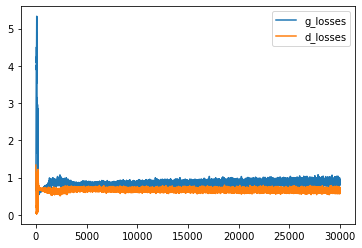

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

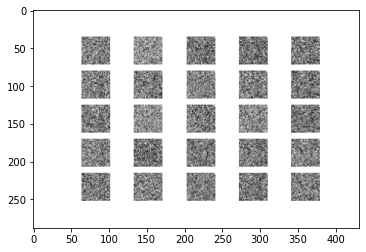

In [ ]:
from skimage.io import imread
a = imread('/content/drive/MyDrive/Projects/GAN/gan_images/0.png')
plt.imshow(a)

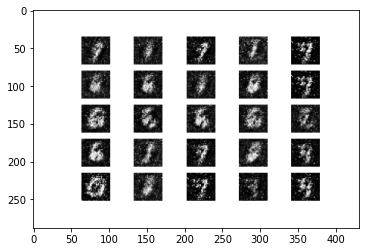

In [ ]:
a = imread('/content/drive/MyDrive/Projects/GAN/gan_images/1000.png')
plt.imshow(a)

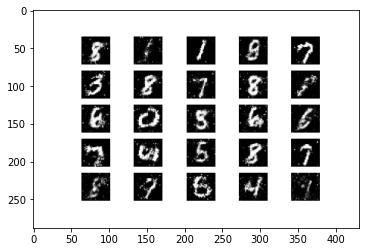

In [ ]:
a = imread('/content/drive/MyDrive/Projects/GAN/gan_images/5000.png')
plt.imshow(a)

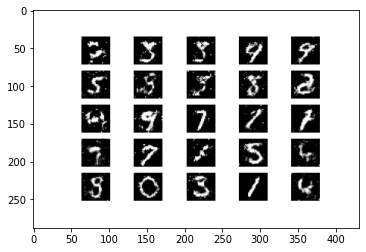

In [ ]:
a = imread('/content/drive/MyDrive/Projects/GAN/gan_images/10000.png')
plt.imshow(a)

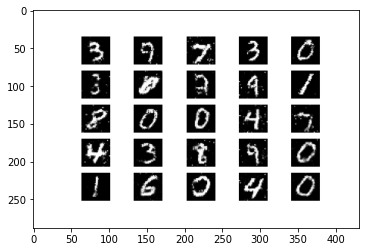

In [ ]:
a = imread('/content/drive/MyDrive/Projects/GAN/gan_images/20000.png')
plt.imshow(a)

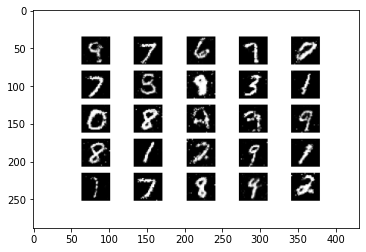

In [ ]:
a = imread('/content/drive/MyDrive/Projects/GAN/gan_images/29800.png')
plt.imshow(a)